In [1]:
import keras
from keras.datasets import mnist
from keras.models import load_model
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

from functools import partial

from collections import defaultdict

import isolearn.keras as iso

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt


Using TensorFlow backend.


In [2]:
#Load MNIST data

dataset_name = "mnist_3_vs_5"

img_rows, img_cols = 28, 28

num_classes = 10
batch_size = 32

included_classes = { 3, 5 }

(x_train, y_train), (x_test, y_test) = mnist.load_data()

keep_index_train = []
for i in range(y_train.shape[0]) :
    if y_train[i] in included_classes :
        keep_index_train.append(i)

keep_index_test = []
for i in range(y_test.shape[0]) :
    if y_test[i] in included_classes :
        keep_index_test.append(i)

x_train = x_train[keep_index_train]
x_test = x_test[keep_index_test]
y_train = y_train[keep_index_train]
y_test = y_test[keep_index_test]

n_train = int((x_train.shape[0] // batch_size) * batch_size)
n_test = int((x_test.shape[0] // batch_size) * batch_size)
x_train = x_train[:n_train]
x_test = x_test[:n_test]
y_train = y_train[:n_train]
y_test = y_test[:n_test]


x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)

input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

print("x_train.shape = " + str(x_train.shape))

print("n train samples = " + str(x_train.shape[0]))
print("n test samples = " + str(x_test.shape[0]))

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

#Binarize images

def _binarize_images(x, val_thresh=0.5) :
    
    x_bin = np.zeros(x.shape)
    x_bin[x >= val_thresh] = 1.
    
    return x_bin

x_train = _binarize_images(x_train, val_thresh=0.5)
x_test = _binarize_images(x_test, val_thresh=0.5)


x_train.shape = (11552, 28, 28, 1)
n train samples = 11552
n test samples = 1888


In [3]:
predictor = Sequential()

predictor.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape, name='conv2d_1'))
predictor.add(Conv2D(64, (3, 3), activation='relu', name='conv2d_2'))
predictor.add(MaxPooling2D(pool_size=(2, 2)))
predictor.add(Dropout(0.25))
predictor.add(Flatten())
predictor.add(Dense(128, activation='relu', name='dense_1'))
predictor.add(Dropout(0.5))
predictor.add(Dense(num_classes, activation='linear', name='dense_2'))

predictor.load_weights('saved_models/mnist_binarized_cnn_10_digits.h5')
predictor.trainable = False

predictor.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adadelta(),
    metrics=['accuracy']
)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [4]:
#Feature substitution, 2D images

digit_test = np.argmax(y_test, axis=1)

importance_scores_test = np.zeros((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))

y_hat_ref = predictor.predict(x_test, batch_size=32, verbose=True)
y_hat_ref = np.array([y_hat_ref[data_ix, digit_test[data_ix]] - np.mean(y_hat_ref[data_ix, :]) for data_ix in range(x_test.shape[0])])

for data_ix in range(x_test.shape[0]) :
    
    if data_ix % 100 == 0 :
        print("Processing example " + str(data_ix) + "...")
    
    x = x_test[data_ix, :, :, :]
    x_var = np.zeros((2 * x.shape[0] * x.shape[1], x.shape[0], x.shape[1], 1))
    
    x_var[:, :, :, :] = x[:, :, :]
    
    for i in range(x_test.shape[1]) :
        for j in range(x_test.shape[2]) :
            x_var[i * x_test.shape[2] + j, i, j, 0] = 1.
            x_var[i * x_test.shape[2] + j, i, j, 0] = 0.
    
            x_var[x_test.shape[1] * x_test.shape[2] + i * x_test.shape[2] + j, i, j, 0] = 0.
            x_var[x_test.shape[1] * x_test.shape[2] + i * x_test.shape[2] + j, i, j, 0] = 1.
    
    y_hat_var = predictor.predict(x_var, batch_size=32)
    y_hat_var = y_hat_var[:, digit_test[data_ix]] - np.mean(y_hat_var[:, :], axis=-1)
    
    for i in range(x_test.shape[1]) :
        for j in range(x_test.shape[2]) :
            importance_scores_test[data_ix, i, j, 0] += np.abs(y_hat_var[i * x_test.shape[2] + j] - y_hat_ref[data_ix])
            importance_scores_test[data_ix, i, j, 0] += np.abs(y_hat_var[x_test.shape[1] * x_test.shape[2] + i * x_test.shape[2] + j] - y_hat_ref[data_ix])


1888/1888 [==============================] - 3s 1ms/step
Processing example 0...
Processing example 100...
Processing example 200...
Processing example 300...
Processing example 400...
Processing example 500...
Processing example 600...
Processing example 700...
Processing example 800...
Processing example 900...
Processing example 1000...
Processing example 1100...
Processing example 1200...
Processing example 1300...
Processing example 1400...
Processing example 1500...
Processing example 1600...
Processing example 1700...
Processing example 1800...


In [5]:
importance_scores_test

array([[[[0.01305389],
         [0.01554871],
         [0.02820206],
         ...,
         [0.01754379],
         [0.00166893],
         [0.00299835]],

        [[0.00806808],
         [0.00383377],
         [0.0296669 ],
         ...,
         [0.02844238],
         [0.04889297],
         [0.00882721]],

        [[0.03899193],
         [0.00134277],
         [0.06876373],
         ...,
         [0.04811478],
         [0.09124756],
         [0.00525665]],

        ...,

        [[0.04961014],
         [0.10145187],
         [0.10399246],
         ...,
         [0.02278137],
         [0.15839767],
         [0.01452255]],

        [[0.02941132],
         [0.07494545],
         [0.07942772],
         ...,
         [0.064991  ],
         [0.0449028 ],
         [0.00099182]],

        [[0.01350403],
         [0.05931473],
         [0.0800705 ],
         ...,
         [0.0779686 ],
         [0.01581955],
         [0.00430679]]],


       [[[0.01001167],
         [0.01621056],
         [0.03

Test image 0:


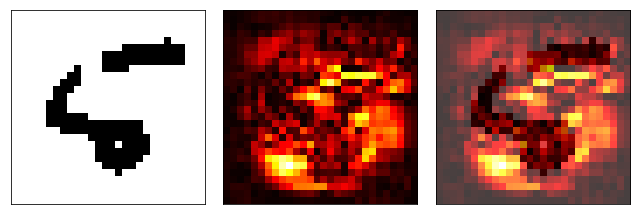

Test image 1:


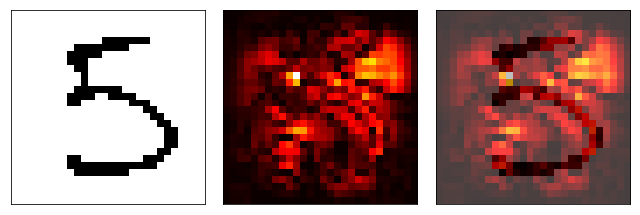

Test image 2:


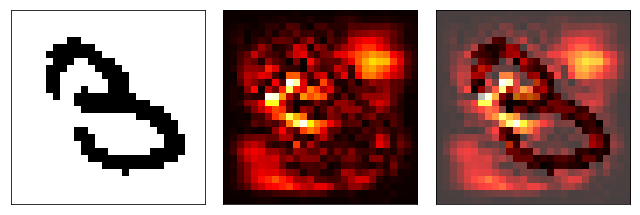

Test image 3:


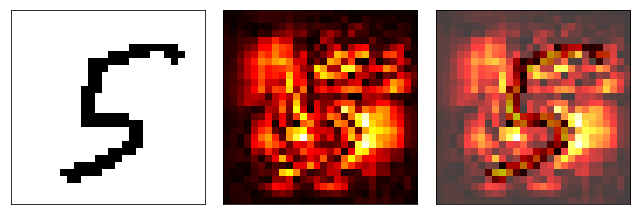

Test image 4:


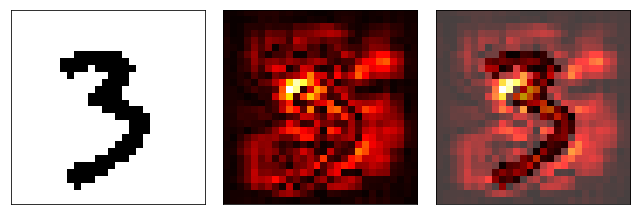

Test image 5:


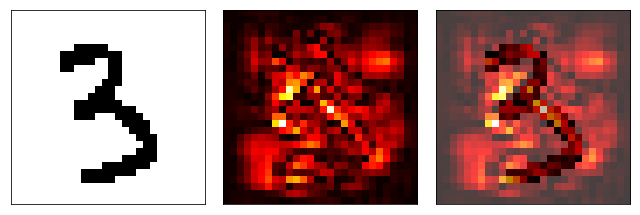

Test image 6:


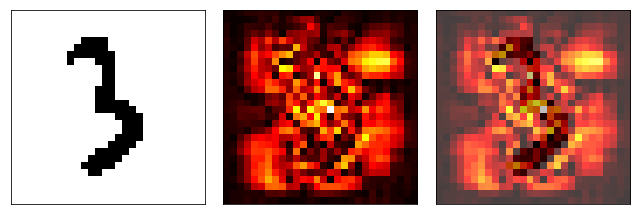

Test image 7:


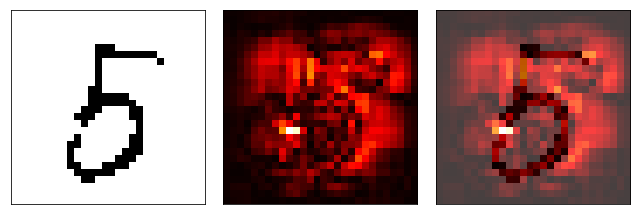

Test image 8:


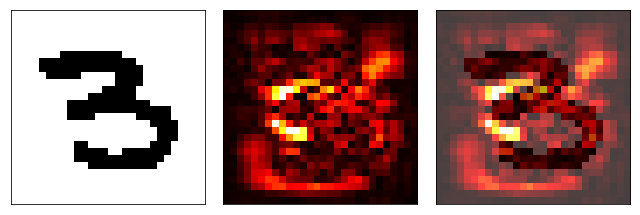

Test image 9:


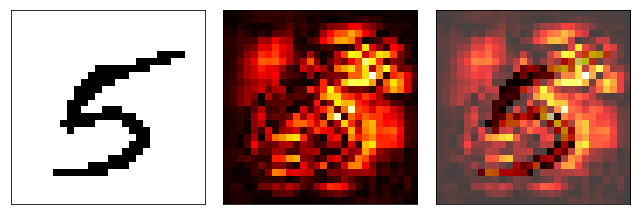

Test image 10:


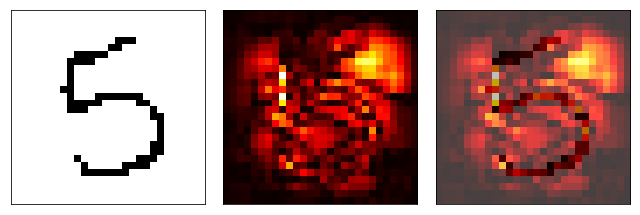

Test image 11:


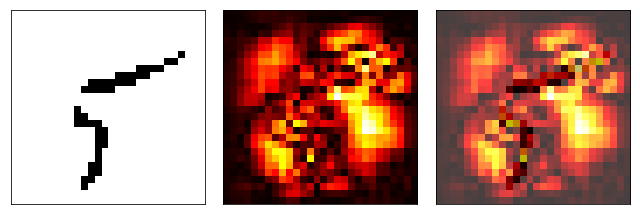

Test image 12:


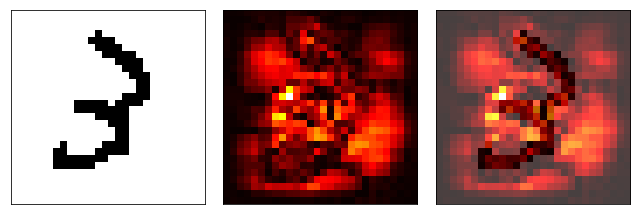

Test image 13:


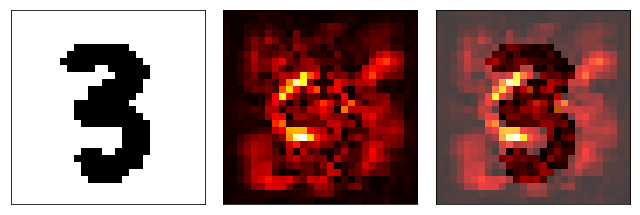

Test image 14:


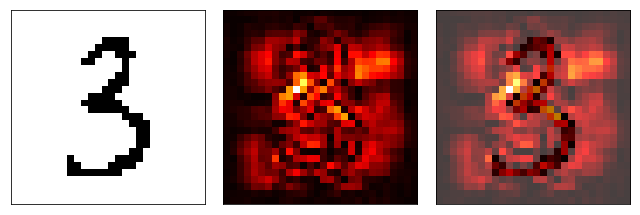

Test image 15:


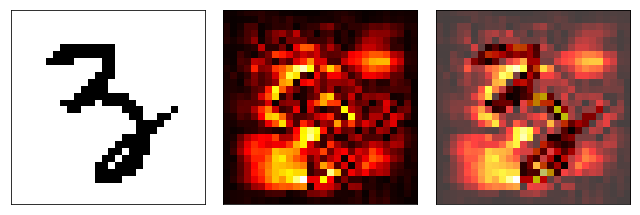

Test image 16:


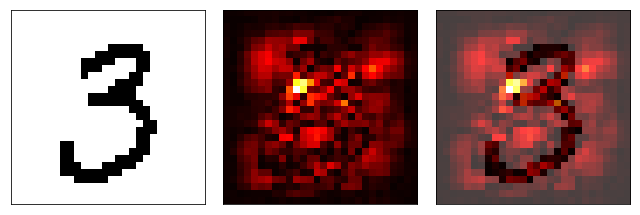

Test image 17:


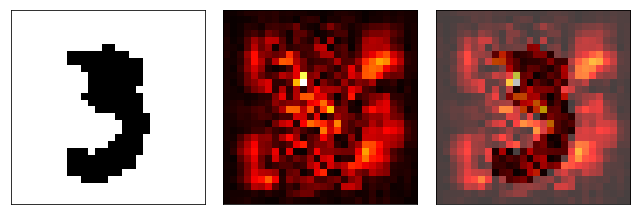

Test image 18:


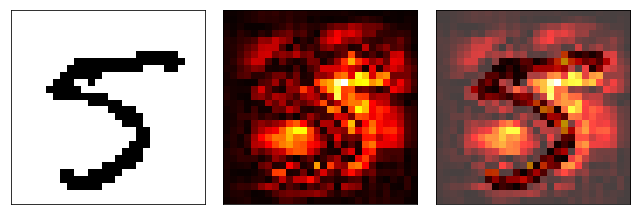

Test image 19:


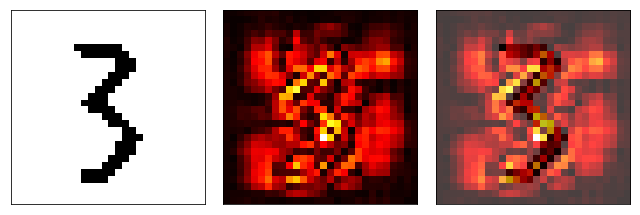

In [6]:
#Visualize a few images

for plot_i in range(0, 20) :
    
    print("Test image " + str(plot_i) + ":")
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(3 * 3, 3))

    ax1.imshow(x_test[plot_i, :, :, 0], cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

    plt.sca(ax1)
    plt.xticks([], [])
    plt.yticks([], [])
    
    ax2.imshow(importance_scores_test[plot_i, :, :, 0], cmap="hot", vmin=0.0, vmax=np.max(importance_scores_test[plot_i, :, :, 0]), aspect='equal')

    plt.sca(ax2)
    plt.xticks([], [])
    plt.yticks([], [])
    
    ax3.imshow(x_test[plot_i, :, :, 0], cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

    ax3.imshow(importance_scores_test[plot_i, :, :, 0], alpha=0.75, cmap="hot", vmin=0.0, vmax=np.max(importance_scores_test[plot_i, :, :, 0]), aspect='equal')

    plt.sca(ax3)
    plt.xticks([], [])
    plt.yticks([], [])

    plt.tight_layout()
    plt.show()


In [7]:
#Save predicted importance scores

model_name = "perturbation_dense_" + dataset_name

np.save(model_name + "_importance_scores_test", importance_scores_test)
